<a href="https://colab.research.google.com/github/ryzvalsa/DL/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import sys, time, os, json
import numpy as np
import matplotlib.pylab as plt
from PIL import Image
from keras.models import *
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def Unet(img_shape):
    def conv2d(x, filters, bn=True):
        x = Conv2D(filters, 4, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    def deconv2d(x, contracting_path, filters, drop_rate=0):
        x = UpSampling2D(2)(x)
        x = Conv2D(filters, 4, padding='same', activation='relu')(x)
        if drop_rate:
            x = Dropout(drop_rate)(x)
        x = BatchNormalization(momentum=0.8)(x)
        return Concatenate()([x, contracting_path])
    img_B = Input(img_shape)
    #エンコーダー
    c1 = conv2d(img_B, 64, False)
    c2 = conv2d(c1, 128)
    c3 = conv2d(c2, 256)
    c4 = conv2d(c3, 512)
    c5 = conv2d(c4, 512)
    c6 = conv2d(c5, 512)
    #中間層
    x = conv2d(c6, 512)
    #デコーダー
    x = deconv2d(x, c6, 512)
    x = deconv2d(x, c5, 512)
    x = deconv2d(x, c4, 512)
    x = deconv2d(x, c3, 256)
    x = deconv2d(x, c2, 128)
    x = deconv2d(x, c1, 64)
    #元サイズ出力
    x = UpSampling2D(2)(x)
    x = Conv2D(img_shape[-1], 4, padding='same', activation='tanh')(x)
    return Model(img_B, x)

def Discriminator(img_shape):
    def d_layer(x, filters, bn=True):
        x = Conv2D(filters, 4, strides=2, padding='same')(x)
        x = LeakyReLU(0.2)(x)
        if bn:
            x = BatchNormalization(momentum=0.8)(x)
        return x
    img_A = Input(img_shape)
    img_B = Input(img_shape)
    x = Concatenate()([img_A, img_B])
    #PatchGANのサイズまで畳み込み
    x = d_layer(x, 64, False)
    x = d_layer(x, 128)
    x = d_layer(x, 256)
    x = d_layer(x, 512)
    #0〜1ラベル出力
    x = Conv2D(1, 4, padding='same')(x)
    return Model([img_A, img_B], x)

def Pix2Pix(gen, disc, img_shape):
    img_A = Input(img_shape)
    img_B = Input(img_shape)
    fake_A = gen(img_B)
    valid = disc([fake_A, img_B])
    return Model([img_A, img_B], [valid, fake_A])

def print_img(e, gen, train_A, train_B, offset, limit, title):
    if e % 10 == 0 or e == 1:
        #データをランダム選択
        num = 10
        idx = 0 #np.random.choice(limit, num, replace=False) + offset
        imgs_A = trainData[idx]
        imgs_B = train_B[idx]
        #生成してみる
        fake_A = gen.predict(imgs_B.astype(np.float32) / 255)
        fake_A = (fake_A * 255).clip(0).astype(np.uint8)
        #繋げる
        imgs_A = np.concatenate(imgs_A, axis=1)
        imgs_B = np.concatenate(imgs_B, axis=1)
        fake_A = np.concatenate(fake_A, axis=1)
        imgs = np.concatenate((imgs_B,imgs_A,fake_A), axis=0)
        #プロット
        plt.figure(figsize=(20, 6))
        plt.title(title)
        plt.imshow(imgs)
        plt.axis('off')
        plt.show()

In [0]:
im = np.array(Image.open('drive/My Drive/データ/data2.png'))

(128, 128, 3)


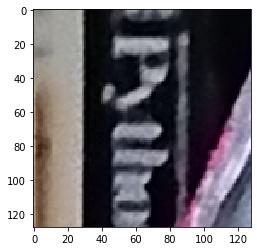

In [0]:
plt.imshow(im)
print(im.shape)

In [0]:
trainData=np.array([[im]])

In [0]:
def train():
    #教師データ
    trainDir=""
    train_num = 1
    test_num = 1
    img_size = 128
    img_shape = (img_size,img_size,3)
    #訓練回数
    epochs = 200
    batch_size = 1
    batch_num = train_num // batch_size
    #前回までの訓練情報
    #info_path = "%s/info.json"%trainDir
    #info = get_json(info_path, lambda: {"epoch":0})
    #PatchGAN
    patch_shape = (img_size//16, img_size//16, 1)
    valid = np.ones((batch_size,) + patch_shape)
    fake = np.zeros((batch_size,) + patch_shape)
    #モデル
    opt = Adam(0.0002, 0.5)
    gen_path = "%s/gen.h5"%""
    disc_path = "%s/disc.h5"%""
    if os.path.isfile(disc_path):
        gen = load_model(gen_path)
        disc = load_model(disc_path)
        print_img(1, gen, train_A, train_B, 0, train_num, "train")
        print_img(1, gen, train_A, train_B, train_num, test_num, "test")
    else:
        gen = Unet(img_shape)
        disc = Discriminator(img_shape)
        disc.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    disc.trainable = False
    pix2pix= Pix2Pix(gen, disc, img_shape)
    pix2pix.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=opt)
    #エポック
    #for e in range(info["epoch"], epochs):
    for e in range(0, epochs):
        start = time.time()
        #ミニバッチ
        for i in range(batch_num):
            #バッチ範囲をランダム選択
            idx = 0 #np.random.choice(train_num, batch_size, replace=False)
            imgs_A = trainData[idx].astype(np.float32) / 255
            imgs_B = trainData[idx].astype(np.float32) / 255
            #識別訓練
            fake_A = gen.predict(imgs_B)
            d_loss_real = disc.train_on_batch([imgs_A, imgs_B], valid)
            d_loss_fake = disc.train_on_batch([fake_A, imgs_B], fake)
            d_loss = np.add(d_loss_real, d_loss_fake) * 0.5
            #生成訓練
            g_loss = pix2pix.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
            #ログ
            print("\repoch:%d/%d batch:%d/%d %ds d_loss:%s g_loss:%s" %
                (e+1,epochs, (i+1),batch_num, (time.time()-start), d_loss[0], g_loss[0]), end="")
            sys.stdout.flush()
        print()
        #画像生成テスト
        print_img(e+1, gen, trainData, trainData, 0, train_num, "train")
        print_img(e+1, gen, trainData, trainData, train_num, test_num, "test")
        #重みの保存
        #gen.save(gen_path)
        #disc.save(disc_path)
        #info["epoch"] += 1
        #with open(info_path, "w") as f:
            #json.dump(info, f)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch:1/200 batch:1/1 40s d_loss:6.8719654 g_loss:65.21587


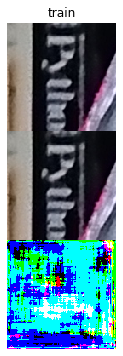

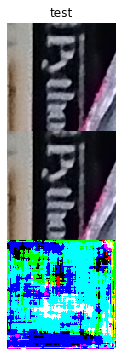

epoch:2/200 batch:1/1 2s d_loss:7.6281824 g_loss:72.27624
epoch:3/200 batch:1/1 2s d_loss:11.430957 g_loss:62.861435
epoch:4/200 batch:1/1 2s d_loss:3.3500285 g_loss:55.89802
epoch:5/200 batch:1/1 2s d_loss:3.4022133 g_loss:50.414093
epoch:6/200 batch:1/1 2s d_loss:4.1921597 g_loss:41.65077
epoch:7/200 batch:1/1 2s d_loss:2.0553033 g_loss:36.25998
epoch:8/200 batch:1/1 2s d_loss:1.010285 g_loss:32.607857
epoch:9/200 batch:1/1 2s d_loss:0.9680526 g_loss:31.782349
epoch:10/200 batch:1/1 2s d_loss:0.9452853 g_loss:31.069935


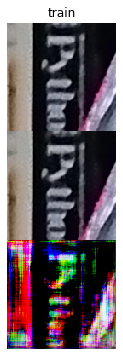

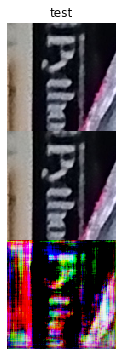

epoch:11/200 batch:1/1 2s d_loss:1.2630675 g_loss:27.053783
epoch:12/200 batch:1/1 2s d_loss:0.9893378 g_loss:26.163769
epoch:13/200 batch:1/1 2s d_loss:0.8413605 g_loss:24.907701
epoch:14/200 batch:1/1 2s d_loss:0.6867291 g_loss:19.974321
epoch:15/200 batch:1/1 2s d_loss:0.4859513 g_loss:19.65198
epoch:16/200 batch:1/1 2s d_loss:0.37114286 g_loss:19.993755
epoch:17/200 batch:1/1 1s d_loss:0.4831503 g_loss:18.966747
epoch:18/200 batch:1/1 2s d_loss:0.73385894 g_loss:17.47225
epoch:19/200 batch:1/1 2s d_loss:0.9017832 g_loss:16.464224
epoch:20/200 batch:1/1 2s d_loss:0.89272344 g_loss:15.612837


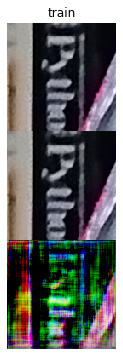

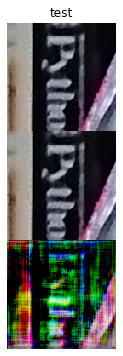

epoch:21/200 batch:1/1 2s d_loss:0.6676902 g_loss:15.303044
epoch:22/200 batch:1/1 2s d_loss:0.27962312 g_loss:15.9627
epoch:23/200 batch:1/1 1s d_loss:0.17369395 g_loss:14.587662
epoch:24/200 batch:1/1 2s d_loss:0.24982974 g_loss:13.159387
epoch:25/200 batch:1/1 2s d_loss:0.40472847 g_loss:12.416752
epoch:26/200 batch:1/1 2s d_loss:0.524983 g_loss:12.317787
epoch:27/200 batch:1/1 2s d_loss:0.44194272 g_loss:12.379351
epoch:28/200 batch:1/1 2s d_loss:0.13911347 g_loss:11.050535
epoch:29/200 batch:1/1 1s d_loss:0.6639519 g_loss:10.599027
epoch:30/200 batch:1/1 2s d_loss:1.0904328 g_loss:11.207696


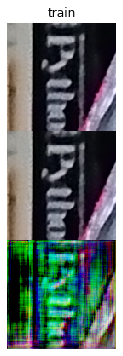

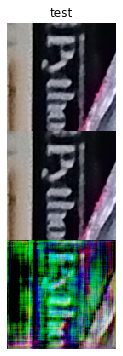

epoch:31/200 batch:1/1 2s d_loss:0.4354924 g_loss:12.4721775
epoch:32/200 batch:1/1 2s d_loss:0.45892 g_loss:11.173221
epoch:33/200 batch:1/1 2s d_loss:0.5221832 g_loss:9.540832
epoch:34/200 batch:1/1 2s d_loss:0.36301076 g_loss:10.354075
epoch:35/200 batch:1/1 2s d_loss:0.19773306 g_loss:8.746402
epoch:36/200 batch:1/1 2s d_loss:0.093375385 g_loss:8.675052
epoch:37/200 batch:1/1 2s d_loss:0.11986095 g_loss:9.181899
epoch:38/200 batch:1/1 2s d_loss:0.3159995 g_loss:8.97441
epoch:39/200 batch:1/1 1s d_loss:0.62314755 g_loss:8.449626
epoch:40/200 batch:1/1 2s d_loss:0.5989431 g_loss:7.2814527


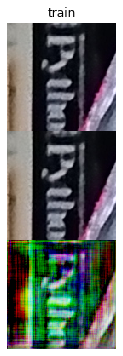

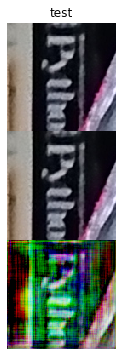

epoch:41/200 batch:1/1 1s d_loss:0.3379173 g_loss:7.268601
epoch:42/200 batch:1/1 1s d_loss:0.14787605 g_loss:7.990101
epoch:43/200 batch:1/1 2s d_loss:0.063809715 g_loss:7.5265217
epoch:44/200 batch:1/1 2s d_loss:0.06822457 g_loss:7.015922
epoch:45/200 batch:1/1 2s d_loss:0.04117244 g_loss:6.5374217
epoch:46/200 batch:1/1 2s d_loss:0.096060835 g_loss:7.8666234
epoch:47/200 batch:1/1 2s d_loss:0.04640938 g_loss:7.460832
epoch:48/200 batch:1/1 2s d_loss:0.05995801 g_loss:9.093463
epoch:49/200 batch:1/1 2s d_loss:0.09800583 g_loss:7.9308023
epoch:50/200 batch:1/1 1s d_loss:0.16462395 g_loss:7.4018407


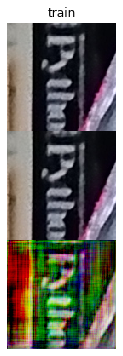

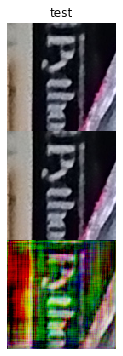

epoch:51/200 batch:1/1 1s d_loss:0.09827642 g_loss:5.8635697
epoch:52/200 batch:1/1 2s d_loss:0.028448515 g_loss:5.7891927
epoch:53/200 batch:1/1 2s d_loss:0.019248232 g_loss:5.525305
epoch:54/200 batch:1/1 2s d_loss:0.02456563 g_loss:5.9206223
epoch:55/200 batch:1/1 1s d_loss:0.026143579 g_loss:6.381354
epoch:56/200 batch:1/1 1s d_loss:0.042471237 g_loss:7.4338274
epoch:57/200 batch:1/1 1s d_loss:0.028002989 g_loss:5.478638
epoch:58/200 batch:1/1 1s d_loss:0.0237176 g_loss:5.864102
epoch:59/200 batch:1/1 1s d_loss:0.01633748 g_loss:6.2144823
epoch:60/200 batch:1/1 1s d_loss:0.028877782 g_loss:6.4898


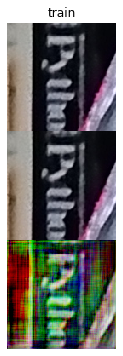

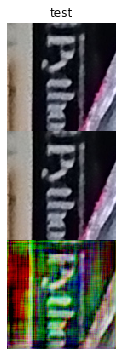

epoch:61/200 batch:1/1 2s d_loss:0.043694273 g_loss:5.8178706
epoch:62/200 batch:1/1 1s d_loss:0.039881848 g_loss:5.5880613
epoch:63/200 batch:1/1 2s d_loss:0.014870878 g_loss:5.267668
epoch:64/200 batch:1/1 1s d_loss:0.015979283 g_loss:5.6817417
epoch:65/200 batch:1/1 1s d_loss:0.023917912 g_loss:5.561368
epoch:66/200 batch:1/1 1s d_loss:0.04655439 g_loss:5.802084
epoch:67/200 batch:1/1 2s d_loss:0.0524418 g_loss:5.7322197
epoch:68/200 batch:1/1 2s d_loss:0.03963889 g_loss:5.542568
epoch:69/200 batch:1/1 1s d_loss:0.020975627 g_loss:5.044893
epoch:70/200 batch:1/1 1s d_loss:0.01478214 g_loss:5.450453


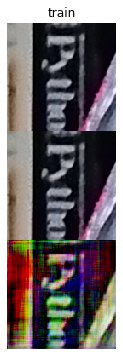

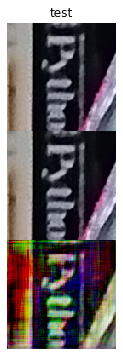

epoch:71/200 batch:1/1 2s d_loss:0.024366066 g_loss:5.73531
epoch:72/200 batch:1/1 1s d_loss:0.037709005 g_loss:6.082151
epoch:73/200 batch:1/1 2s d_loss:0.057443563 g_loss:5.7568426
epoch:74/200 batch:1/1 2s d_loss:0.0461994 g_loss:5.4472675
epoch:75/200 batch:1/1 2s d_loss:0.03931476 g_loss:6.155443
epoch:76/200 batch:1/1 2s d_loss:0.025675869 g_loss:4.978429
epoch:77/200 batch:1/1 2s d_loss:0.038883064 g_loss:4.8763685
epoch:78/200 batch:1/1 2s d_loss:0.03811609 g_loss:5.4457684
epoch:79/200 batch:1/1 1s d_loss:0.044600554 g_loss:5.2386208
epoch:80/200 batch:1/1 1s d_loss:0.028002223 g_loss:4.821256


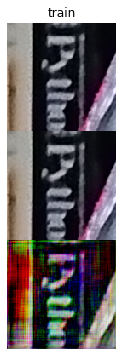

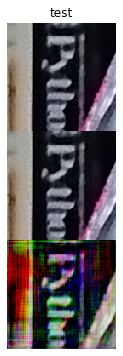

epoch:81/200 batch:1/1 2s d_loss:0.034919884 g_loss:5.120565
epoch:82/200 batch:1/1 2s d_loss:0.033856787 g_loss:4.853895
epoch:83/200 batch:1/1 2s d_loss:0.051039245 g_loss:5.298917
epoch:84/200 batch:1/1 1s d_loss:0.050604906 g_loss:4.7198677
epoch:85/200 batch:1/1 2s d_loss:0.042950623 g_loss:5.0054173
epoch:86/200 batch:1/1 2s d_loss:0.08125484 g_loss:4.2557034
epoch:87/200 batch:1/1 1s d_loss:0.04015278 g_loss:4.8558216
epoch:88/200 batch:1/1 2s d_loss:0.11928593 g_loss:4.832766
epoch:89/200 batch:1/1 1s d_loss:0.088889584 g_loss:5.653286
epoch:90/200 batch:1/1 2s d_loss:0.27124405 g_loss:4.368143


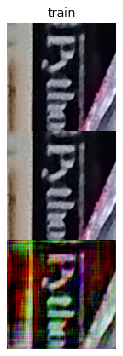

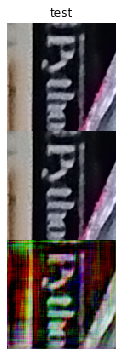

epoch:91/200 batch:1/1 2s d_loss:0.12620646 g_loss:5.511775
epoch:92/200 batch:1/1 1s d_loss:0.21045557 g_loss:5.3858175
epoch:93/200 batch:1/1 1s d_loss:0.16421553 g_loss:5.196117
epoch:94/200 batch:1/1 2s d_loss:0.1818704 g_loss:4.3117547
epoch:95/200 batch:1/1 2s d_loss:0.16850445 g_loss:4.804681
epoch:96/200 batch:1/1 1s d_loss:0.06293244 g_loss:5.1730285
epoch:97/200 batch:1/1 1s d_loss:0.089704104 g_loss:5.023276
epoch:98/200 batch:1/1 2s d_loss:0.06756692 g_loss:4.5256467
epoch:99/200 batch:1/1 2s d_loss:0.046617128 g_loss:3.869074
epoch:100/200 batch:1/1 1s d_loss:0.057079464 g_loss:4.6975613


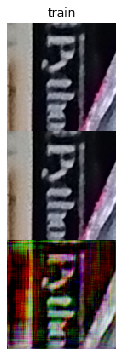

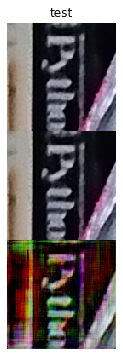

epoch:101/200 batch:1/1 2s d_loss:0.025663642 g_loss:4.850814
epoch:102/200 batch:1/1 1s d_loss:0.021715846 g_loss:4.3366213
epoch:103/200 batch:1/1 2s d_loss:0.033338383 g_loss:4.5937037
epoch:104/200 batch:1/1 2s d_loss:0.022630926 g_loss:4.822315
epoch:105/200 batch:1/1 2s d_loss:0.026152462 g_loss:4.4879317
epoch:106/200 batch:1/1 2s d_loss:0.02826234 g_loss:4.4073057
epoch:107/200 batch:1/1 2s d_loss:0.022651963 g_loss:4.6464787
epoch:108/200 batch:1/1 2s d_loss:0.03277167 g_loss:4.3457932
epoch:109/200 batch:1/1 1s d_loss:0.02076219 g_loss:4.083146
epoch:110/200 batch:1/1 2s d_loss:0.013475882 g_loss:4.622765


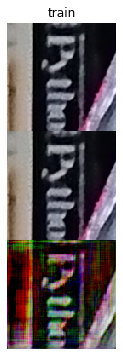

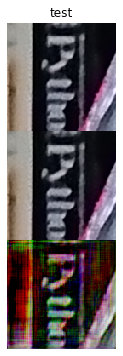

epoch:111/200 batch:1/1 2s d_loss:0.021156346 g_loss:4.2291136
epoch:112/200 batch:1/1 1s d_loss:0.014585169 g_loss:4.736445
epoch:113/200 batch:1/1 2s d_loss:0.018224481 g_loss:3.9464486
epoch:114/200 batch:1/1 2s d_loss:0.026098466 g_loss:4.3968663
epoch:115/200 batch:1/1 2s d_loss:0.04664021 g_loss:4.0002747
epoch:116/200 batch:1/1 1s d_loss:0.037722647 g_loss:4.4978385
epoch:117/200 batch:1/1 2s d_loss:0.026402619 g_loss:4.2510133
epoch:118/200 batch:1/1 2s d_loss:0.040564045 g_loss:4.9537926
epoch:119/200 batch:1/1 1s d_loss:0.036842763 g_loss:3.9230716
epoch:120/200 batch:1/1 1s d_loss:0.031701956 g_loss:4.336601


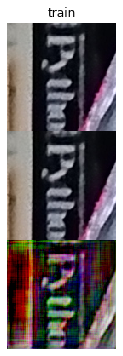

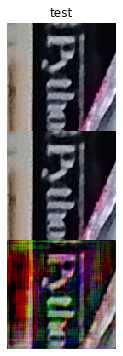

epoch:121/200 batch:1/1 2s d_loss:0.022256 g_loss:4.3141837
epoch:122/200 batch:1/1 1s d_loss:0.04088056 g_loss:4.3750315
epoch:123/200 batch:1/1 2s d_loss:0.047443837 g_loss:4.243783
epoch:124/200 batch:1/1 1s d_loss:0.057600223 g_loss:4.637349
epoch:125/200 batch:1/1 2s d_loss:0.03175816 g_loss:4.1378026
epoch:126/200 batch:1/1 2s d_loss:0.043309625 g_loss:4.162936
epoch:127/200 batch:1/1 1s d_loss:0.032995965 g_loss:4.0349298
epoch:128/200 batch:1/1 2s d_loss:0.037257634 g_loss:4.452999
epoch:129/200 batch:1/1 2s d_loss:0.112544045 g_loss:3.9234717
epoch:130/200 batch:1/1 1s d_loss:0.109064884 g_loss:3.9609227


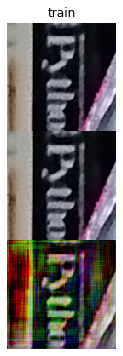

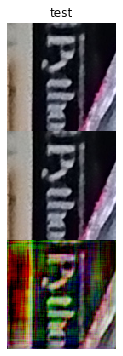

epoch:131/200 batch:1/1 2s d_loss:0.10738315 g_loss:4.1945486
epoch:132/200 batch:1/1 2s d_loss:0.040105402 g_loss:4.4042993
epoch:133/200 batch:1/1 2s d_loss:0.13957065 g_loss:4.094088
epoch:134/200 batch:1/1 2s d_loss:0.12332088 g_loss:3.9499223
epoch:135/200 batch:1/1 2s d_loss:0.13781828 g_loss:3.822033
epoch:136/200 batch:1/1 1s d_loss:0.086400025 g_loss:4.2278957
epoch:137/200 batch:1/1 2s d_loss:0.08015478 g_loss:4.336034
epoch:138/200 batch:1/1 1s d_loss:0.18202543 g_loss:4.071947
epoch:139/200 batch:1/1 1s d_loss:0.22200619 g_loss:4.027065
epoch:140/200 batch:1/1 2s d_loss:0.12356054 g_loss:4.133985


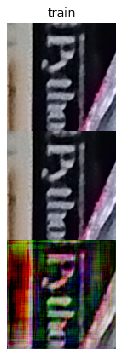

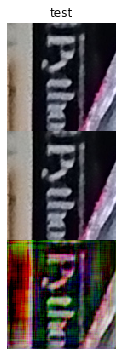

epoch:141/200 batch:1/1 2s d_loss:0.044543974 g_loss:4.1789455
epoch:142/200 batch:1/1 2s d_loss:0.05851899 g_loss:3.8331523
epoch:143/200 batch:1/1 2s d_loss:0.1200924 g_loss:4.2985463
epoch:144/200 batch:1/1 2s d_loss:0.13449493 g_loss:3.8800325
epoch:145/200 batch:1/1 2s d_loss:0.091680236 g_loss:3.619792
epoch:146/200 batch:1/1 2s d_loss:0.016006524 g_loss:3.8418922
epoch:147/200 batch:1/1 2s d_loss:0.04296775 g_loss:3.828317
epoch:148/200 batch:1/1 2s d_loss:0.14341344 g_loss:3.8937838
epoch:149/200 batch:1/1 1s d_loss:0.1505913 g_loss:3.7914264
epoch:150/200 batch:1/1 2s d_loss:0.08299181 g_loss:3.8677077


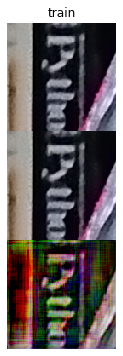

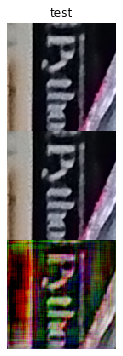

epoch:151/200 batch:1/1 2s d_loss:0.047887385 g_loss:3.7425709
epoch:152/200 batch:1/1 1s d_loss:0.08904037 g_loss:4.2684684
epoch:153/200 batch:1/1 2s d_loss:0.1432957 g_loss:3.827507
epoch:154/200 batch:1/1 1s d_loss:0.120934494 g_loss:3.6096592
epoch:155/200 batch:1/1 2s d_loss:0.033065103 g_loss:3.9579716
epoch:156/200 batch:1/1 1s d_loss:0.06272271 g_loss:4.223463
epoch:157/200 batch:1/1 2s d_loss:0.18247195 g_loss:3.7793715
epoch:158/200 batch:1/1 2s d_loss:0.17546216 g_loss:3.950508
epoch:159/200 batch:1/1 2s d_loss:0.11483755 g_loss:3.7414176
epoch:160/200 batch:1/1 2s d_loss:0.1251865 g_loss:3.9743147


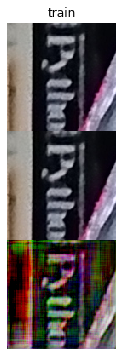

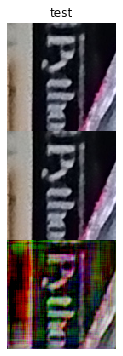

epoch:161/200 batch:1/1 2s d_loss:0.100049496 g_loss:3.6467636
epoch:162/200 batch:1/1 2s d_loss:0.15529788 g_loss:4.049506
epoch:163/200 batch:1/1 2s d_loss:0.190658 g_loss:3.6755676
epoch:164/200 batch:1/1 2s d_loss:0.25222456 g_loss:3.8467026
epoch:165/200 batch:1/1 2s d_loss:0.17141244 g_loss:3.595555
epoch:166/200 batch:1/1 2s d_loss:0.11018543 g_loss:4.0831532
epoch:167/200 batch:1/1 2s d_loss:0.15315843 g_loss:3.5606575
epoch:168/200 batch:1/1 2s d_loss:0.19483614 g_loss:3.7606173
epoch:169/200 batch:1/1 2s d_loss:0.16662276 g_loss:3.3196964
epoch:170/200 batch:1/1 2s d_loss:0.105084576 g_loss:3.4833384


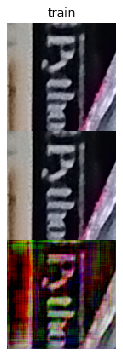

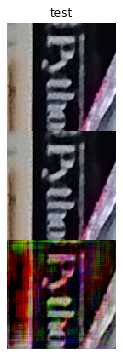

epoch:171/200 batch:1/1 2s d_loss:0.06354834 g_loss:3.6268928
epoch:172/200 batch:1/1 2s d_loss:0.072316036 g_loss:3.7854037
epoch:173/200 batch:1/1 2s d_loss:0.07139754 g_loss:3.5312881
epoch:174/200 batch:1/1 2s d_loss:0.0542673 g_loss:3.5482733
epoch:175/200 batch:1/1 2s d_loss:0.034102242 g_loss:3.3476362
epoch:176/200 batch:1/1 2s d_loss:0.036949936 g_loss:3.750474
epoch:177/200 batch:1/1 1s d_loss:0.03228137 g_loss:3.275022
epoch:178/200 batch:1/1 2s d_loss:0.02906707 g_loss:3.6241264
epoch:179/200 batch:1/1 2s d_loss:0.037380047 g_loss:3.232844
epoch:180/200 batch:1/1 2s d_loss:0.033688 g_loss:3.4557402


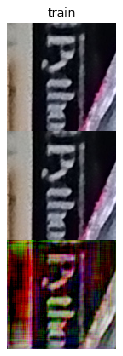

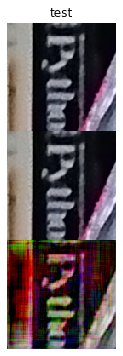

epoch:181/200 batch:1/1 2s d_loss:0.033241246 g_loss:3.4020958
epoch:182/200 batch:1/1 1s d_loss:0.02690611 g_loss:3.7028942
epoch:183/200 batch:1/1 2s d_loss:0.022136692 g_loss:3.2570653
epoch:184/200 batch:1/1 2s d_loss:0.013102865 g_loss:3.5166466
epoch:185/200 batch:1/1 2s d_loss:0.012166074 g_loss:3.7220263
epoch:186/200 batch:1/1 2s d_loss:0.020429362 g_loss:3.3488796
epoch:187/200 batch:1/1 1s d_loss:0.0149357105 g_loss:3.3687117
epoch:188/200 batch:1/1 2s d_loss:0.011015712 g_loss:3.310709
epoch:189/200 batch:1/1 2s d_loss:0.011628895 g_loss:3.4983046
epoch:190/200 batch:1/1 2s d_loss:0.010044238 g_loss:3.5156689


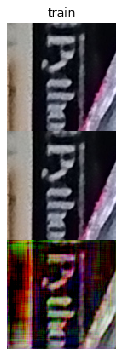

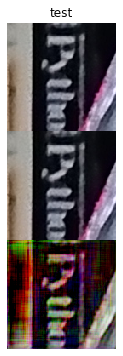

epoch:191/200 batch:1/1 2s d_loss:0.021322971 g_loss:3.0067842
epoch:192/200 batch:1/1 1s d_loss:0.018182456 g_loss:3.3915107
epoch:193/200 batch:1/1 2s d_loss:0.028064426 g_loss:3.4335566
epoch:194/200 batch:1/1 2s d_loss:0.023127887 g_loss:3.3912444
epoch:195/200 batch:1/1 2s d_loss:0.02165286 g_loss:3.0640273
epoch:196/200 batch:1/1 1s d_loss:0.028205987 g_loss:3.22053
epoch:197/200 batch:1/1 1s d_loss:0.019073004 g_loss:3.3261302
epoch:198/200 batch:1/1 2s d_loss:0.03138772 g_loss:3.1713502
epoch:199/200 batch:1/1 1s d_loss:0.021959146 g_loss:3.0063007
epoch:200/200 batch:1/1 2s d_loss:0.064774945 g_loss:3.077077


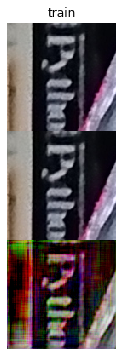

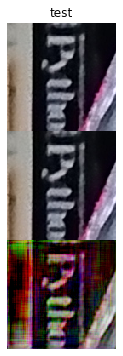

In [0]:
train()
